In [1]:
import sys
# sys.path
# sys.path[5] = "C:\\ProgramData\\Anaconda3\\envs\\geoplot\\Lib\\site-packages"

import matplotlib.path as mpath
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from osgeo import gdal
import pandas as pd

# import rasterio
#PlateCarree EqualEarth()

In [2]:
def get_geotiff_data(path):
    """
    get gdal raster data
    """
    ds = gdal.Open(path)
    gt = ds.GetGeoTransform()
    array = ds.ReadAsArray()
    
    xsize = ds.RasterXSize
    ysize = ds.RasterYSize
    
    xres, yres = gt[1], gt[5]
    xcor, ycor = gt[0], gt[3]
    
    lat = np.arange(ycor, ycor + yres*ysize, yres)
    lon = np.arange(xcor, xcor + xres*xsize, xres)
    return lon, lat, array

In [3]:
def draw(ax1, title, lon, lat, array, vmin, vmax, levels, cmap, number):
    ax1.outline_patch.set_linewidth(0.3)
    #Setting colour properties
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    array[array==-9999] = np.nan
    cs = ax1.contourf(lon, lat, array, transform=ccrs.PlateCarree(), cmap=cmap,levels=levels, norm=norm, shading='nearest', extend="max")
    cbar = fig.colorbar(cs, orientation='horizontal', pad=0.09, shrink=1, fraction=0.03, aspect=50)
    # ax1.set_title(title, fontsize='medium')
    #Modify the length of the scale
    cbar.ax.tick_params(size=1)
    cbar.outline.set_linewidth(0.2)
    ax1.add_feature(cfeature.BORDERS, linewidth=0.15)
    ax1.set_global()
    ax1.coastlines(linewidth=0.2)
    a = ax1.gridlines(draw_labels=True, linewidth=0.2)
    a.top_labels = False
    ax1.text(
        0.65, 0.1, title,
        fontsize=10,
        style="italic",
        transform = ax1.transAxes
    )
    ax1.text(
        -0.03, 0.95, number,
        fontsize=8,
        transform = ax1.transAxes
    )

In [4]:
def draw_2(ax1, title, lon, lat, array, vmin, vmax, levels, cmap, number):
    ax1.outline_patch.set_linewidth(0.3)
    #Setting colour properties
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    array[array==-9999] = np.nan
    cs = ax1.contourf(lon, lat, array, transform=ccrs.PlateCarree(), cmap=cmap,levels=levels, norm=norm, shading='nearest', extend="both")
    cbar = fig.colorbar(cs, orientation='horizontal', pad=0.09, shrink=1, fraction=0.03, aspect=50)
    # ax1.set_title(title, fontsize='medium')
    #Modify the length of the scale
    cbar.ax.tick_params(size=1)
    cbar.outline.set_linewidth(0.2)
    ax1.add_feature(cfeature.BORDERS, linewidth=0.15)
    ax1.set_global()
    ax1.coastlines(linewidth=0.2)
    a = ax1.gridlines(draw_labels=True, linewidth=0.2)
    a.top_labels = False
    ax1.text(
        0.65, 0.1, title,
        fontsize=10,
        style="italic",
        transform = ax1.transAxes
    )
    ax1.text(
        -0.03, 0.95, number,
        fontsize=8,
        transform = ax1.transAxes
    )

In [5]:
def draw_area_plot(ax, levels_input, data, cmap):
    
    
    x = np.arange(-59.875, 90.125, 0.25)
    levels= list(levels_input)
    levels.append(1)
    levels = np.array(levels)
    if levels_input.shape[0] == 6:
        columns=["c1", "c2", "c3", "c4", "c5", "c6"]
    elif levels_input.shape[0] == 7:
        columns=["c1", "c2", "c3", "c4", "c5", "c6", "c7"]
    elif levels_input.shape[0] == 10:
        columns=["c1", "c2", "c3", "c4", "c5", "c6", "c7", "c8", "c9", "c10"]
    df_out = pd.DataFrame(columns=columns)
    for i in range(len(x)):
        df = pd.DataFrame(data[i, :])
        df.drop(index=df[df[0]<-1].index, axis=0, inplace=True)
        df["cut"] = pd.cut(df[0], bins=levels)
        gb = df.groupby(["cut"])
        df = gb.count()
        df_out.loc[i, :] = np.array(df[0])

    for i in range(len(df_out)):
        if df_out.loc[i, :].sum() == 0:
            continue
        else:
            df_out.loc[i, :] = df_out.loc[i, :] / df_out.loc[i, :].sum()

    for i in range(len(df_out)):
        for j in range(len(columns)):
            if j == 0:
                continue
            else:
                df_out.iloc[i, j] = df_out.iloc[i, j] + df_out.iloc[i, j-1]

    
    colors = []
    levels2 = levels_input
    cmap = plt.get_cmap(cmap)
    norm = plt.Normalize(0, 400)
    n = len(levels_input)
    space = levels[1] - levels[0]
    for l in levels_input:
        c = ((l+(space/2))/(levels_input[-1]+space)) * 400
        colors.append(cmap(norm(c)))

    for i, col in enumerate(df_out.columns):
        ax.fill_betweenx(x, np.array(df_out.loc[:, col][::-1], dtype=np.float32), label=col, zorder=-i, color=colors[i])
    ax.margins(0, 0)
    ax.set_xlim(0)
    ax.set_ylim(-55, 85)
    ax.set_axisbelow(False)
    ax.set_xlabel("Proportion")
    ax.set_ylabel("latitude")
    
    ax.spines["bottom"].set_linewidth(0.3)
    ax.spines["top"].set_linewidth(0.3)
    ax.spines["left"].set_linewidth(0.3)
    ax.spines["right"].set_linewidth(0.3)
    
    ax.tick_params("x",which="major",
               length=1.34,width = 0.8,
               colors = "0.25")
    ax.tick_params("y",which="major",
                   length=1.34,width = 0.8,
                   colors = "0.25")
    ax.tick_params(which = "minor",
                   length = 1.34, width = 0.8,
                   labelsize=10,labelcolor = "0.25")

In [6]:
def draw_proportion_chart(ax, data, levels_input, cmap):
    
    levels= list(levels_input)
    levels.append(1)
    levels = np.array(levels)

    data = data.ravel()
    df = pd.DataFrame(data)
    df.drop(index=df[df[0]<-1].index, axis=0, inplace=True)
    df["cut"] = pd.cut(df[0], bins=levels)
    gb = df.groupby(["cut"])
    df = gb.count()
    # df_out.loc[0] = np.array(df[0])
    colors = []
    levels2 = levels_input
    cmap = plt.get_cmap(cmap)
    norm = plt.Normalize(0, 400)
    n = len(levels_input)
    space = levels[1] - levels[0]
    for l in levels_input:
        c = ((l+(space/2))/(levels_input[-1]+space)) * 400
        colors.append(cmap(norm(c)))


    # Pie 1
    wedges, texts = ax.pie(df[0], radius=1, colors=colors)

    for w in wedges:
        w.set_width(.5)

    wedges[0].set_visible(False)

    # Pie 2
    wedges1, texts1 = ax.pie(df[0], radius=1.1, colors=colors)

    for w in wedges1:
        w.set_width(.6)

    wedges1[1].set_visible(False)
    wedges1[2].set_visible(False)
    wedges1[3].set_visible(False)

In [7]:
# input_folder = "E:\\weather extreme\\pr_record_breaking_proba_uncertain\\V2\\"
output_folder = "G:\\weather extreme\\mapping_result\\"

C:\Users\Bohao Li\AppData\Local\Temp\ipykernel_30900\1643424878.py:2: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax1.outline_patch.set_linewidth(0.3)
C:\Users\Bohao Li\AppData\Local\Temp\ipykernel_30900\1643424878.py:2: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax1.outline_patch.set_linewidth(0.3)
D:\software\Anaconda\envs\geomapping\lib\site-packages\cartopy\mpl\geoaxes.py:1714: UserWarning: The following kwargs were not used by contour: 'shading'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
C:\Users\Bohao Li\AppData\Local\Temp\ipykernel_30900\1643424878.py:2: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax1.outline_patch.set_linewidth(0.3)
D:\software\Anaconda\envs\geomapping\lib\site-packages\cartopy\mpl\geoa

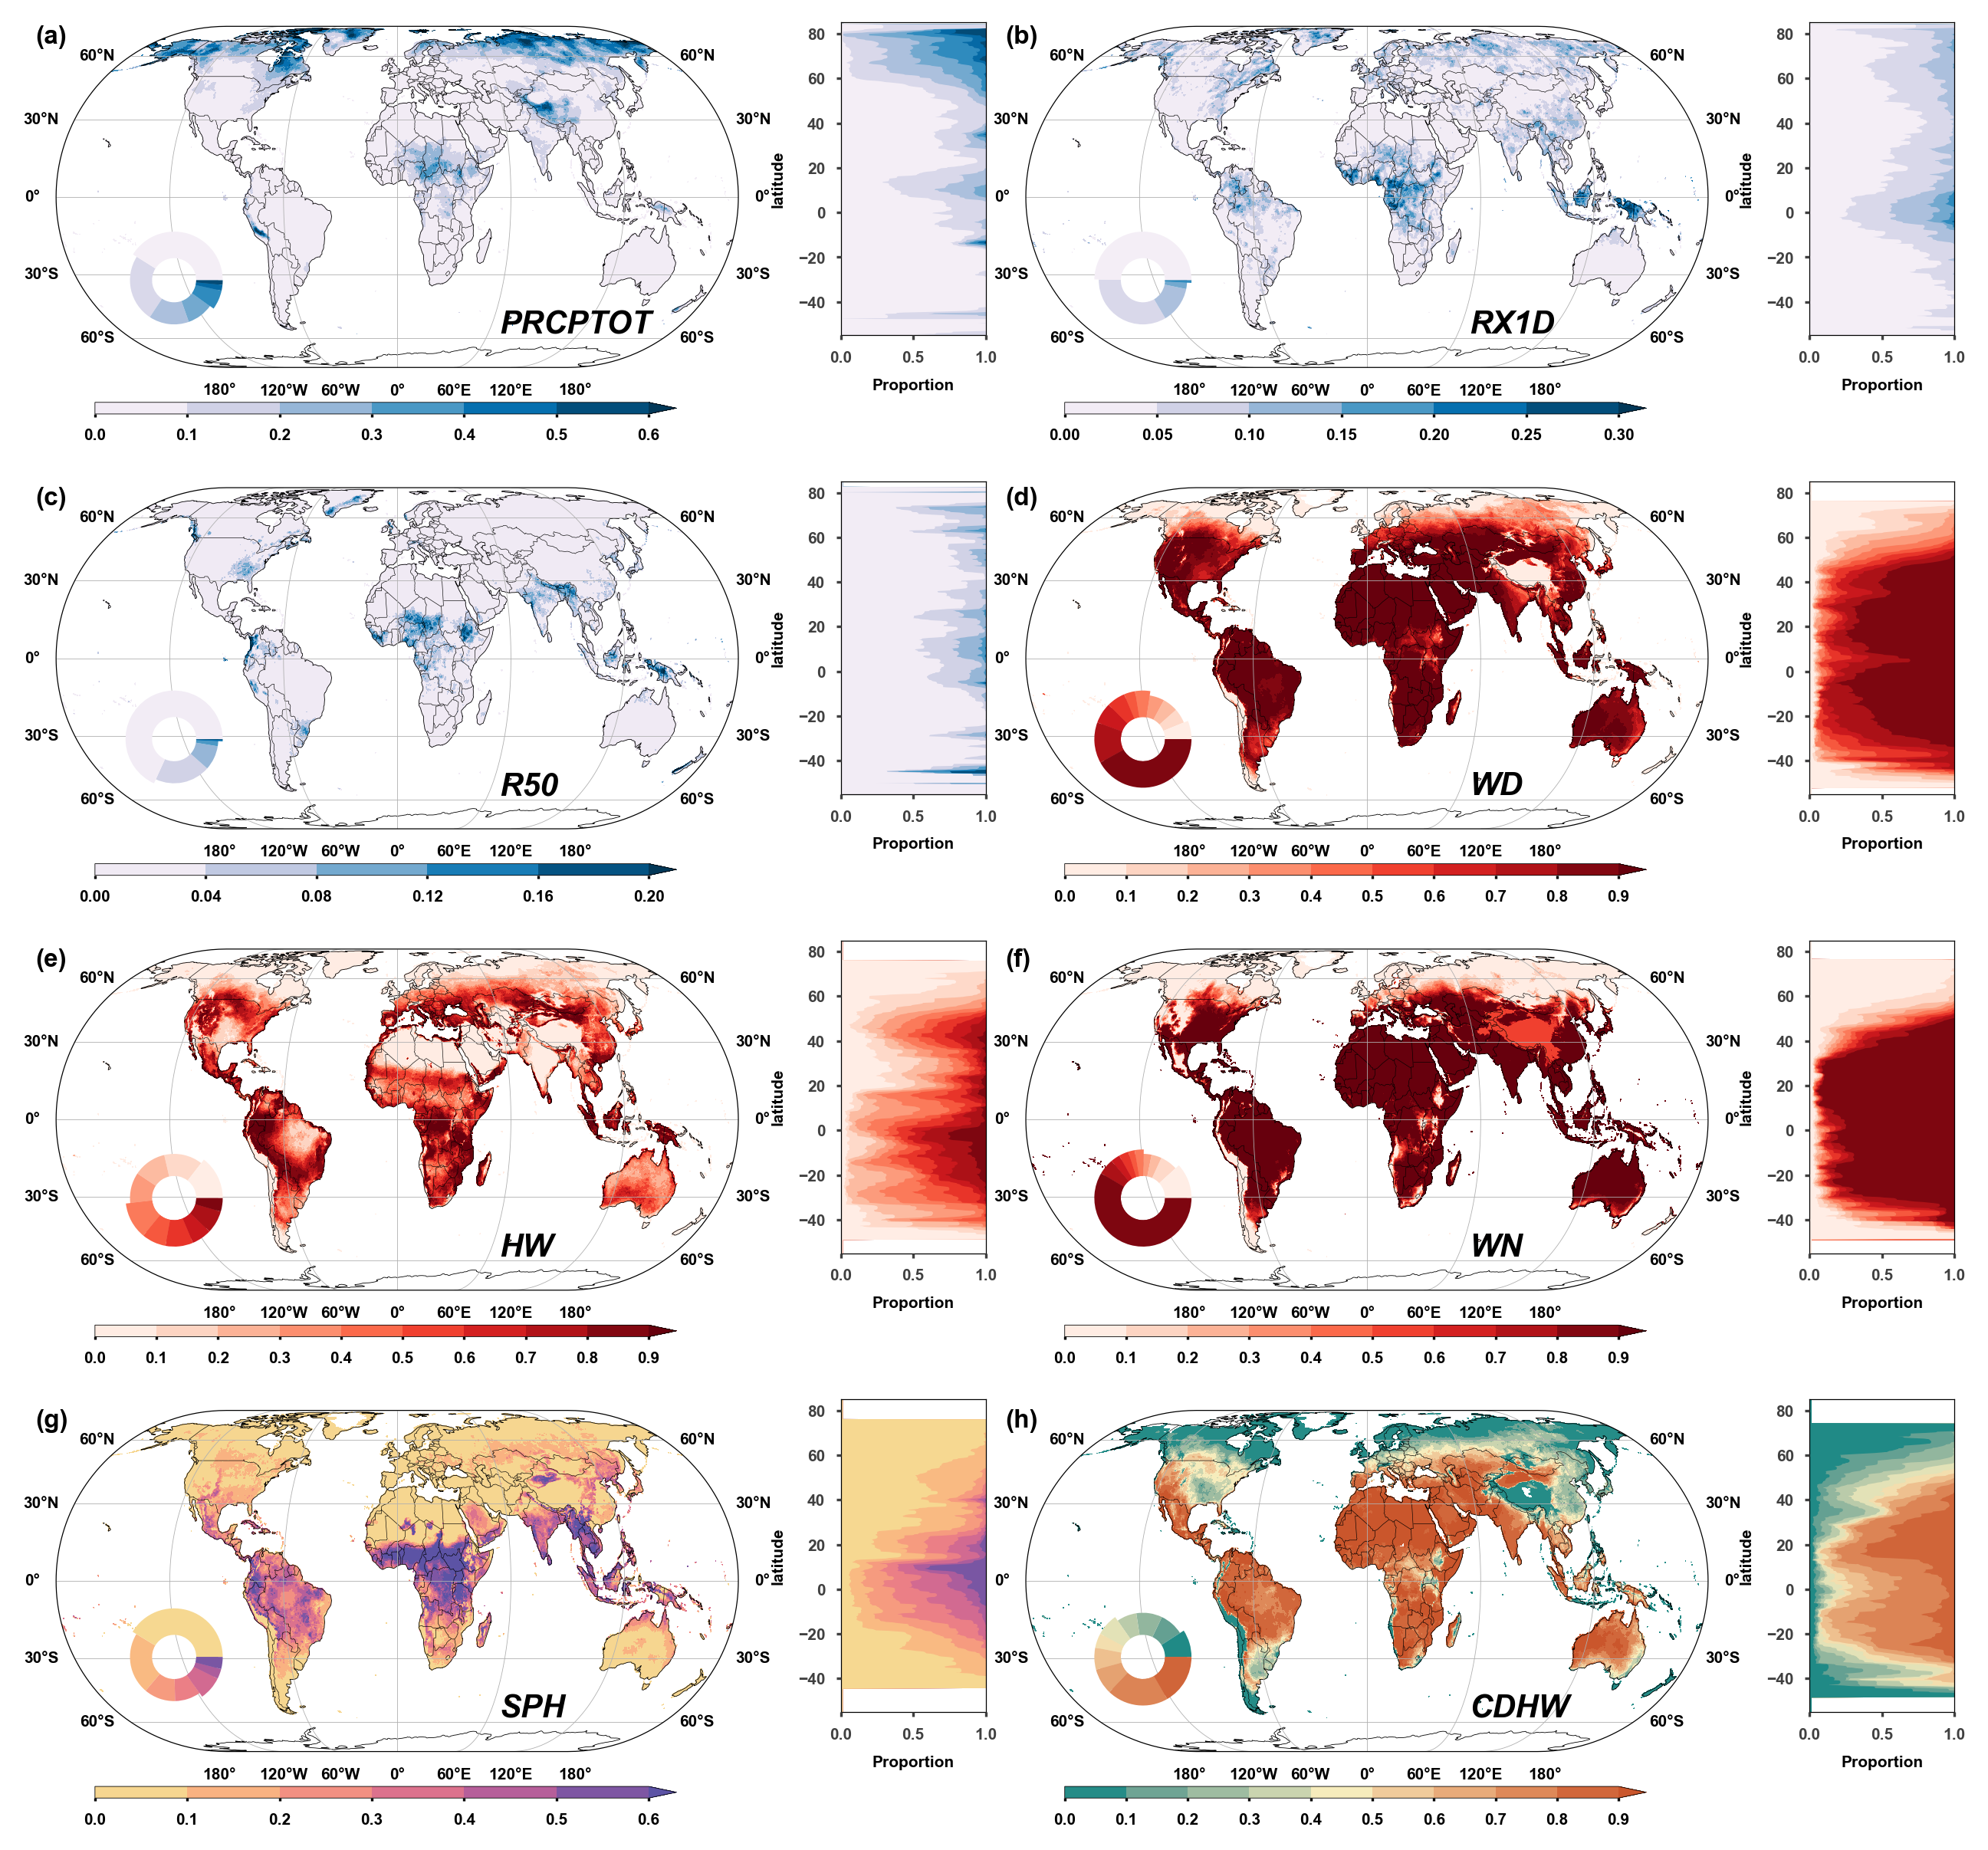

In [10]:
#precipitation CM YlGnBu
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
clist = ["#fff7fb", "#ece7f2", "#d0d1e6", "#a6bddb", "#74a9cf", "#3690c0", "#0570b0", "#045a8d", "#023858"]
newcmap_pr = LinearSegmentedColormap.from_list('chaos',clist)

clist = ["#f3e79b","#fac484","#f8a07e","#eb7f86","#ce6693","#a059a0","#5c53a5"]
newcmap_SFH = LinearSegmentedColormap.from_list('chaos',clist)

clist = ["#008080","#70a494","#b4c8a8","#f6edbd","#edbb8a","#de8a5a","#ca562c"]
newcmap_CDHW = LinearSegmentedColormap.from_list('chaos',clist)

fig = plt.figure(figsize=(9,8), dpi=300)

plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams.update({"font.size":5})
projection = ccrs.EckertIV()

ax1 = fig.add_subplot(4, 2, 1,
                      projection=projection)
lon, lat, array = get_geotiff_data(r"G:\weather extreme\mapping_data\pr_record_breaking_proba_uncertain\V2\accumulate_pr_lat_ssp370_median.tif")
draw(ax1, 'PRCPTOT', lon, lat, array, vmin=0, vmax=0.6, levels=np.arange(0, 0.70, 0.1), cmap=newcmap_pr, number="(a)")

ax11 = plt.axes([0.48, 0.82, 0.07, 0.170])
draw_area_plot(ax11, np.arange(0, 0.70, 0.1), array, newcmap_pr)

ax111 = plt.axes([0.128, 0.82, 0.06, 0.06])
draw_proportion_chart(ax111, array, np.arange(0, 0.70, 0.1), newcmap_pr)

ax2 = fig.add_subplot(4, 2, 2,
                      projection=projection)
lon, lat, array = get_geotiff_data(r"G:\weather extreme\mapping_data\pr_record_breaking_proba_uncertain\V2\max_daily_pr_lat_ssp370_median.tif")
draw(ax2, 'RX1D', lon, lat, array, vmin=0, vmax=0.3, levels=np.arange(0, 0.35, 0.05), cmap=newcmap_pr, number="(b)")

ax12 = plt.axes([0.948, 0.82, 0.07, 0.170])
draw_area_plot(ax12, np.arange(0, 0.35, 0.05), array, newcmap_pr)

ax122 = plt.axes([0.596, 0.82, 0.06, 0.06])
draw_proportion_chart(ax122, array, np.arange(0, 0.35, 0.05), newcmap_pr)

ax3 = fig.add_subplot(4, 2, 3,
                      projection=projection)
lon, lat, array = get_geotiff_data(r"G:\weather extreme\mapping_data\pr_record_breaking_proba_uncertain\V2\preceed50mm_pr_lat_ssp370_median.tif")
draw(ax3, 'R50', lon, lat, array, vmin=0, vmax=0.2, levels=np.arange(0, 0.24, 0.04), cmap=newcmap_pr, number="(c)")

ax33 = plt.axes([0.48, 0.5706, 0.07, 0.170])
draw_area_plot(ax33, np.arange(0, 0.24, 0.04), array, newcmap_pr)

ax333 = plt.axes([0.128, 0.5706, 0.06, 0.06])
draw_proportion_chart(ax333, array, np.arange(0, 0.24, 0.04), newcmap_pr)

ax4 = fig.add_subplot(4, 2, 4,
                      projection=projection)
lon, lat, array = get_geotiff_data(r"G:\weather extreme\Revision\heat(tasmax)\WD_record_breaking_uncertain\WD_lat_ssp370_median.tif")
draw(ax4, 'WD', lon, lat, array, vmin=0, vmax=0.9, levels=np.arange(0, 1, 0.1), cmap='Reds', number="(d)")

ax44 = plt.axes([0.948, 0.5706, 0.07, 0.170])
draw_area_plot(ax44, np.arange(0, 1, 0.1), array, 'Reds')

ax444 = plt.axes([0.596, 0.5706, 0.06, 0.06])
draw_proportion_chart(ax444, array, np.arange(0, 1, 0.1), 'Reds')

ax5 = fig.add_subplot(4, 2, 5,
                      projection=projection)
lon, lat, array = get_geotiff_data(r"G:\weather extreme\Revision\heatwave\HW_record_breaking_prob_uncertain\HW_lat_ssp370_median.tif")
draw(ax5, 'HW', lon, lat, array, vmin=0, vmax=0.9, levels=np.arange(0, 1, 0.1), cmap='Reds', number="(e)")

ax55 = plt.axes([0.48, 0.3212, 0.07, 0.170])
draw_area_plot(ax55, np.arange(0, 1, 0.1), array, 'Reds')

ax555 = plt.axes([0.128, 0.3212, 0.06, 0.06])
draw_proportion_chart(ax555, array, np.arange(0, 1, 0.1), 'Reds')

ax6 = fig.add_subplot(4, 2, 6,
                      projection=projection)
lon, lat, array = get_geotiff_data(r"G:\weather extreme\Revision\warmnight(tasmin)\WN_record_breaking_prob_uncertain\WN_lat_ssp370_median.tif")
draw(ax6, 'WN', lon, lat, array, vmin=0, vmax=0.9, levels=np.arange(0, 1, 0.1), cmap='Reds', number="(f)")

ax66 = plt.axes([0.948, 0.3212, 0.07, 0.170])
draw_area_plot(ax66, np.arange(0, 1, 0.1), array, 'Reds')

ax666 = plt.axes([0.596, 0.3212, 0.06, 0.06])
draw_proportion_chart(ax666, array, np.arange(0, 1, 0.1), 'Reds')

ax7 = fig.add_subplot(4, 2, 7,
                      projection=projection)
lon, lat, array = get_geotiff_data(r"G:\weather extreme\Revision\SPH\SPH_record_breaking_prob_uncertain\SPH_lat_ssp370_median.tif")
draw(ax7, 'SPH', lon, lat, array, vmin=0, vmax=0.6, levels=np.arange(0, 0.7, 0.1), cmap=newcmap_SFH, number="(g)")

ax77 = plt.axes([0.48, 0.0718, 0.07, 0.170])
draw_area_plot(ax77, np.arange(0, 0.7, 0.1), array, newcmap_SFH)

ax777 = plt.axes([0.128, 0.0718, 0.06, 0.06])
draw_proportion_chart(ax777, array, np.arange(0, 0.7, 0.1), newcmap_SFH)

ax8 = fig.add_subplot(4, 2, 8,
                      projection=projection)
lon, lat, array = get_geotiff_data(r"G:\weather extreme\Revision\CDHW\CDHW_record_breaking_prob_uncertain\CDHW_lat_ssp370_median.tif")
draw(ax8, 'CDHW', lon, lat, array, vmin=0, vmax=0.9, levels=np.arange(0, 1, 0.1), cmap=newcmap_CDHW, number="(h)")

ax88 = plt.axes([0.948, 0.0718, 0.07, 0.170])
draw_area_plot(ax88, np.arange(0, 1, 0.1), array, newcmap_CDHW)

ax888 = plt.axes([0.596, 0.0718, 0.06, 0.06])
draw_proportion_chart(ax888, array, np.arange(0, 1, 0.1), newcmap_CDHW)

#  xticks = [-180, -120, -60, 0, 60, 120, 180]
# ax.set_xticks(xticks, crs=proj)
# ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=proj)
# lon_formatter = mticker.LongitudeFormatter(zero_direction_label=True)
# lat_formatter = mticker.LatitudeFormatter()
# ax.xaxis.set_major_formatter(lon_formatter)
# ax.yaxis.set_major_formatter(lat_formatter)
plt.tight_layout(h_pad=2.5)
plt.savefig(output_folder + "extreme_ssp370_median_revised.jpg", dpi=1000, bbox_inches="tight")
plt.show()